# CellType classification model 

In [1]:
# import zipfile
# with zipfile.ZipFile('./Image_classification_data.zip', 'r') as zip_ref:
#     zip_ref.extractall('./')

Import all the required libraries

In [2]:
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

Load mainData and extraData into dataframes

In [3]:
mainData = pd.read_csv('./data_labels_mainData.csv')
extraData = pd.read_csv('./data_labels_extraData.csv')

mainData

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0
...,...,...,...,...,...,...
9891,1625,60,1625.png,epithelial,2,1
9892,1626,60,1626.png,epithelial,2,1
9893,1627,60,1627.png,epithelial,2,1
9894,1628,60,1628.png,epithelial,2,1


In [4]:
mainData.cellTypeName.value_counts()

epithelial      4079
inflammatory    2543
fibroblast      1888
others          1386
Name: cellTypeName, dtype: int64

Check for any null values

Check if to see any null values exists

In [5]:
mainData.isnull().sum()

InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64

We remove the `InstanceID` column to prevent any data leaks and the `isCancerous` column since we are only predicting the cell type

In [6]:
mainData.drop(['InstanceID'], axis=1,inplace=True)
mainData.drop(['isCancerous'], axis=1,inplace=True)

In [7]:
print("#### mainData shape ####\n")
print(mainData.shape)
print("\n#### mainData info ####\n")
print(mainData.info())
print("\n#### mainData describe ####\n")
print(mainData.describe())

#### mainData shape ####

(9896, 4)

#### mainData info ####

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   patientID     9896 non-null   int64 
 1   ImageName     9896 non-null   object
 2   cellTypeName  9896 non-null   object
 3   cellType      9896 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 309.4+ KB
None

#### mainData describe ####

         patientID     cellType
count  9896.000000  9896.000000
mean     29.762025     1.501516
std      17.486553     0.954867
min       1.000000     0.000000
25%      14.000000     1.000000
50%      26.000000     2.000000
75%      47.000000     2.000000
max      60.000000     3.000000


Create a dictionary with label mapping for future predictions.

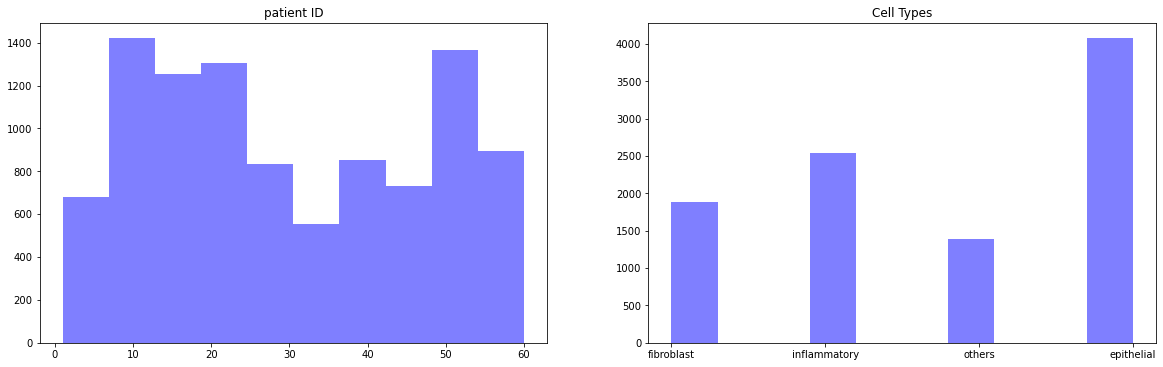

In [8]:
plt.figure(figsize=(20,20))
plt.subplot(3, 2, 1)
plt.hist(mainData['patientID'], facecolor='blue', alpha=0.5)
plt.title('patient ID')

plt.subplot(3, 2, 2)
plt.hist(mainData['cellTypeName'], facecolor='blue', alpha=0.5)
plt.title('Cell Types')
plt.show()

In [9]:
cellType_map = mainData.set_index('cellType').to_dict()['cellTypeName']

In [10]:
mainData['cellType'] = mainData['cellType'].astype('category')

## Train test validation split

In [11]:
train_data, test_data = train_test_split(mainData, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

In [12]:
print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 5937, Val Data: 1979, Test Data: 1980


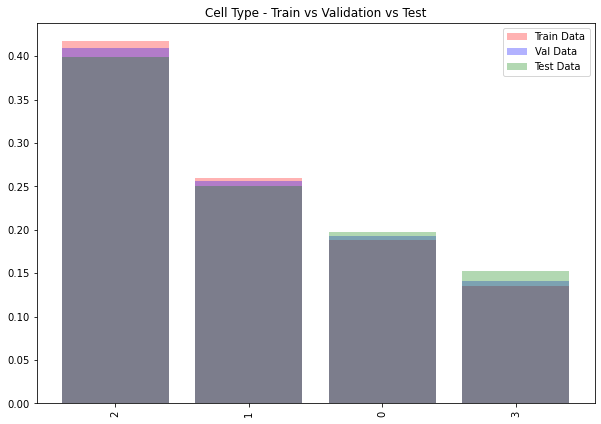

In [13]:
plt.figure(figsize=(10,7))
plt.bar(
    train_data.cellType.value_counts().index.astype(str), 
    train_data.cellType.value_counts().values/np.sum(train_data.cellType.value_counts().values), 
    alpha=0.3, 
    color='r',
    label='Train Data'
)
plt.bar(
    val_data.cellType.value_counts().index.astype(str), 
    val_data.cellType.value_counts().values/np.sum(val_data.cellType.value_counts().values), 
    alpha=0.3, 
    color='b',
    label='Val Data'
)
plt.bar(
    test_data.cellType.value_counts().index.astype(str), 
    test_data.cellType.value_counts().values/np.sum(test_data.cellType.value_counts().values), 
    alpha=0.3, 
    color='g',
    label='Test Data'
)

plt.title('Cell Type - Train vs Validation vs Test')
plt.xticks(rotation='vertical')
plt.legend()

## One hot encoding the labels

In [14]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_encode(df, col, col_names = None):
    ohe = OneHotEncoder(handle_unknown = 'ignore')
    ohe.fit(df[[col]])
    
    ohe_ = ohe.transform(df[[col]]).toarray()
    
    if (col_names == None):
        col_names = ohe.categories_[0]
        
        for i in range(len(ohe.categories_[0])):
            df[col + '_' + str(col_names[i])] = ohe_[:,i]
            
        df.drop(col, axis = 1, inplace = True)

In [15]:
one_hot_encode(train_data, 'cellType')
one_hot_encode(val_data, 'cellType')
one_hot_encode(test_data, 'cellType')

<ipython-input-14-ba2fe6a3a20f>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col + '_' + str(col_names[i])] = ohe_[:,i]
/home/magnuscake/miniconda3/envs/tf_cpu/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## Image preprocessing

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescale is done here to normalize the pixels in a range of 0-1
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

# This the default batch size
batch_size = 32
columns = ['cellType_0', 'cellType_1', 'cellType_2', 'cellType_3']

train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_data,
    directory = './patch_images',
    x_col = 'ImageName',
    y_col = columns,
    target_size = (27, 27),
    batch_size = batch_size,
    class_mode = 'raw',
    shuffle=False
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe = val_data,
    directory = './patch_images',
    x_col = 'ImageName',
    y_col = columns,
    target_size = (27, 27),
    batch_size = batch_size,
    class_mode = 'raw',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_data,
    directory = './patch_images',
    x_col = 'ImageName',
    y_col = columns,
    target_size = (27, 27),
    batch_size = batch_size,
    class_mode = 'raw',
    shuffle=False
)

Found 5937 validated image filenames.
Found 1979 validated image filenames.
Found 1980 validated image filenames.


# Utility Functions

## Plot functions

In [17]:
# Learning curve diagnostic tool
def plot_fit_history(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [18]:
# def plot_confusion_matrix(test, pred):
#     cm = confusion_matrix(test, pred)
#     group_names = ['True Neg','False Pos','False Neg','True Pos']
#     group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
#     group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
#     labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
#     labels = np.asarray(labels).reshape(2,2)
#     sns.heatmap(cm, annot=True, fmt='', cmap='Blues')

def plot_confusion_matrix(test, pred,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    cm = confusion_matrix(test, pred)
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

## Model development functions

In [19]:
def compile_model(model):
    sgd = tf.keras.optimizers.SGD(learning_rate=0.01)
#     opt = tf.keras.optimizers.Adagrad()
    
    model.compile(optimizer=sgd,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy', 'accuracy'])

In [20]:
early_stopping_monitor = EarlyStopping(patience=10, monitor='val_categorical_accuracy')

def fit_model(model):

    print('start ', datetime.datetime.now().strftime("%H:%M:%S"))
    now = datetime.datetime.now()

    fit_history = model.fit(train_generator, validation_data = validation_generator, 
                            callbacks=[early_stopping_monitor], epochs=10000, verbose=1)

    print('stop ', datetime.datetime.now().strftime("%H:%M:%S"))
    print("Took = ", datetime.datetime.now() - now)
    
    return fit_history

In [21]:
def predict_model(model):
    batch_size_ = 1
    y_pred = list()
    y_test = list()
    filenames = test_generator.filenames
    N_images = len(filenames)
    batches = 0

    # iterate through the data generator and predict for each batch
    # hold the predictions and labels
    for x,y in test_generator:
            yp = model.predict(x, verbose=0)
            yp = np.argmax(yp, axis = 1)
            yt = np.argmax(y, axis = 1)
            y_pred = y_pred + yp.tolist()
            y_test = y_test + yt.tolist()

            batches += 1
            if batches >= N_images / batch_size_:
                break
                
    return (y_test, y_pred)

In [22]:
def show_stats(y_test, y_pred):
    print("Accuracy score: ", accuracy_score(test_y, pred_y))
    print("F1 score: ", f1_score(test_y, pred_y, average='macro'))

    print(classification_report(test_y, pred_y, zero_division=0))

# Baseline model

In [23]:
INPUT_DIM = (27, 27, 3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 4 # Flag for output layer

base_model = keras.Sequential([
    keras.layers.Flatten(input_shape=INPUT_DIM),
    keras.layers.Dense(HIDDEN_LAYER_DIM, activation='relu'),
    keras.layers.Dense(OUTPUT_CLASSES)
])

In [24]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2187)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               560128    
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
Total params: 561,156
Trainable params: 561,156
Non-trainable params: 0
_________________________________________________________________


Initial the optimizer to use with the learning rate.

In [25]:
compile_model(base_model)

In [26]:
base_history = fit_model(base_model)

start  10:55:43
Epoch 1/10000
186/186 [==============================] - 3s 12ms/step - loss: 1.2810 - categorical_accuracy: 0.4529 - accuracy: 0.4529 - val_loss: 1.1409 - val_categorical_accuracy: 0.5801 - val_accuracy: 0.5801
Epoch 2/10000
186/186 [==============================] - 2s 12ms/step - loss: 1.0797 - categorical_accuracy: 0.5526 - accuracy: 0.5526 - val_loss: 1.0309 - val_categorical_accuracy: 0.5159 - val_accuracy: 0.5159
Epoch 3/10000
186/186 [==============================] - 2s 12ms/step - loss: 1.0001 - categorical_accuracy: 0.5905 - accuracy: 0.5905 - val_loss: 1.0966 - val_categorical_accuracy: 0.5346 - val_accuracy: 0.5346
Epoch 4/10000
186/186 [==============================] - 2s 12ms/step - loss: 0.9409 - categorical_accuracy: 0.6202 - accuracy: 0.6202 - val_loss: 0.8716 - val_categorical_accuracy: 0.6589 - val_accuracy: 0.6589
Epoch 5/10000
186/186 [==============================] - 2s 12ms/step - loss: 0.9119 - categorical_accuracy: 0.6328 - accuracy: 0.6328 -

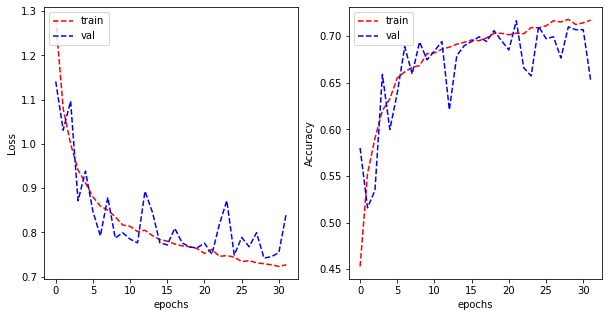

In [27]:
plot_fit_history(base_history.history['loss'], base_history.history['val_loss'],
                    base_history.history['categorical_accuracy'], base_history.history['val_categorical_accuracy'])

Trying some regularization

In [46]:
reg_lambda = 0.001

reg_model = keras.Sequential([
    keras.layers.Flatten(input_shape=INPUT_DIM),
    keras.layers.Dense(HIDDEN_LAYER_DIM, activation='relu', kernel_regularizer=keras.regularizers.l2(reg_lambda)),
    keras.layers.Dense(OUTPUT_CLASSES, activation='relu', kernel_regularizer=keras.regularizers.l2(reg_lambda))
])

In [47]:
compile_model(reg_model)

In [48]:
reg_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 2187)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               560128    
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 1028      
Total params: 561,156
Trainable params: 561,156
Non-trainable params: 0
_________________________________________________________________


In [49]:
reg_history = fit_model(reg_model)

start  11:15:34
Epoch 1/10000
186/186 [==============================] - 3s 14ms/step - loss: 1.7775 - categorical_accuracy: 0.3771 - accuracy: 0.3771 - val_loss: 1.6387 - val_categorical_accuracy: 0.4416 - val_accuracy: 0.4416
Epoch 2/10000
186/186 [==============================] - 2s 13ms/step - loss: 1.6386 - categorical_accuracy: 0.4474 - accuracy: 0.4474 - val_loss: 1.7401 - val_categorical_accuracy: 0.4047 - val_accuracy: 0.4047
Epoch 3/10000
186/186 [==============================] - 2s 13ms/step - loss: 1.5860 - categorical_accuracy: 0.4671 - accuracy: 0.4671 - val_loss: 1.5259 - val_categorical_accuracy: 0.4750 - val_accuracy: 0.4750
Epoch 4/10000
186/186 [==============================] - 2s 13ms/step - loss: 1.5421 - categorical_accuracy: 0.4875 - accuracy: 0.4875 - val_loss: 1.5146 - val_categorical_accuracy: 0.4634 - val_accuracy: 0.4634
Epoch 5/10000
186/186 [==============================] - 2s 13ms/step - loss: 1.5242 - categorical_accuracy: 0.4959 - accuracy: 0.4959 -

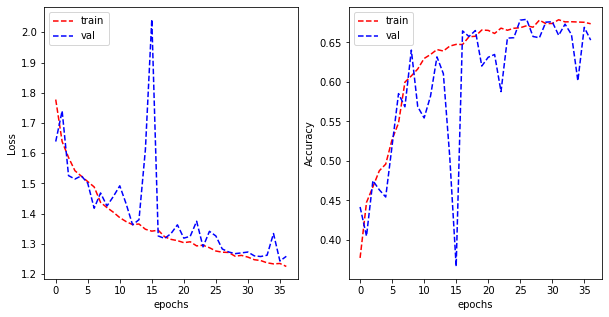

In [50]:
plot_fit_history(reg_history.history['loss'], reg_history.history['val_loss'],
                    reg_history.history['categorical_accuracy'], reg_history.history['val_categorical_accuracy'])

In [51]:
(test_y, pred_y) = predict_model(reg_model)

In [52]:
show_stats(test_y, pred_y)

Accuracy score:  0.6439777327935222
F1 score:  0.5598254745213944
              precision    recall  f1-score   support

           0       0.72      0.25      0.37     12483
           1       0.73      0.56      0.64     15842
           2       0.76      0.94      0.84     25257
           3       0.32      0.51      0.39      9650

    accuracy                           0.64     63232
   macro avg       0.63      0.57      0.56     63232
weighted avg       0.68      0.64      0.63     63232



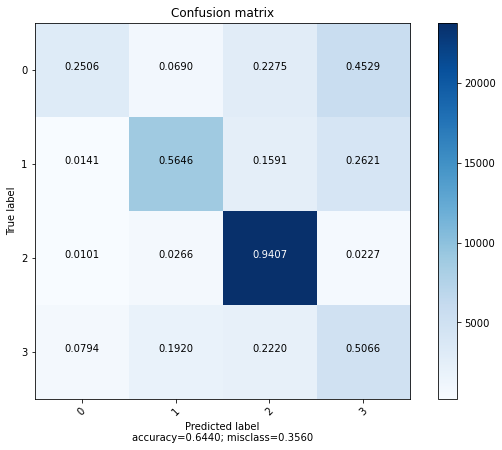

In [53]:
plot_confusion_matrix(test_y, pred_y, [0, 1, 2, 3])

## Base VGG model

In [54]:
VGG_model = keras.Sequential([
    #VGG block 1
    keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2, 2)),
    
    keras.layers.Flatten(),
    
    keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(reg_lambda)),
    keras.layers.Dense(OUTPUT_CLASSES, activation='relu', kernel_regularizer=keras.regularizers.l2(reg_lambda))
])

In [55]:
compile_model(VGG_model)

In [56]:
VGG_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 27, 27, 32)        896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 27, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 6, 6, 128)        

In [57]:
VGG_history = fit_model(VGG_model)

start  11:18:22
Epoch 1/10000
186/186 [==============================] - 16s 83ms/step - loss: 1.6195 - categorical_accuracy: 0.2580 - accuracy: 0.2580 - val_loss: 1.6161 - val_categorical_accuracy: 0.2567 - val_accuracy: 0.2567
Epoch 2/10000
186/186 [==============================] - 16s 87ms/step - loss: 1.6120 - categorical_accuracy: 0.2609 - accuracy: 0.2609 - val_loss: 1.6099 - val_categorical_accuracy: 0.2567 - val_accuracy: 0.2567
Epoch 3/10000
186/186 [==============================] - 17s 89ms/step - loss: 1.6000 - categorical_accuracy: 0.2668 - accuracy: 0.2668 - val_loss: 1.5886 - val_categorical_accuracy: 0.2804 - val_accuracy: 0.2804
Epoch 4/10000
186/186 [==============================] - 17s 91ms/step - loss: 1.5775 - categorical_accuracy: 0.2838 - accuracy: 0.2838 - val_loss: 1.5579 - val_categorical_accuracy: 0.3254 - val_accuracy: 0.3254
Epoch 5/10000
186/186 [==============================] - 17s 90ms/step - loss: 1.5438 - categorical_accuracy: 0.3195 - accuracy: 0.3

186/186 [==============================] - 17s 89ms/step - loss: 0.6826 - categorical_accuracy: 0.8073 - accuracy: 0.8073 - val_loss: 0.9331 - val_categorical_accuracy: 0.7054 - val_accuracy: 0.7054
Epoch 40/10000
186/186 [==============================] - 16s 87ms/step - loss: 0.6350 - categorical_accuracy: 0.8316 - accuracy: 0.8316 - val_loss: 0.9750 - val_categorical_accuracy: 0.7150 - val_accuracy: 0.7150
Epoch 41/10000
186/186 [==============================] - 16s 87ms/step - loss: 0.6453 - categorical_accuracy: 0.8297 - accuracy: 0.8297 - val_loss: 0.9953 - val_categorical_accuracy: 0.6832 - val_accuracy: 0.6832
Epoch 42/10000
186/186 [==============================] - 18s 94ms/step - loss: 0.5857 - categorical_accuracy: 0.8530 - accuracy: 0.8530 - val_loss: 1.0035 - val_categorical_accuracy: 0.7064 - val_accuracy: 0.7064
Epoch 43/10000
186/186 [==============================] - 17s 92ms/step - loss: 0.5688 - categorical_accuracy: 0.8560 - accuracy: 0.8560 - val_loss: 1.1728 - v

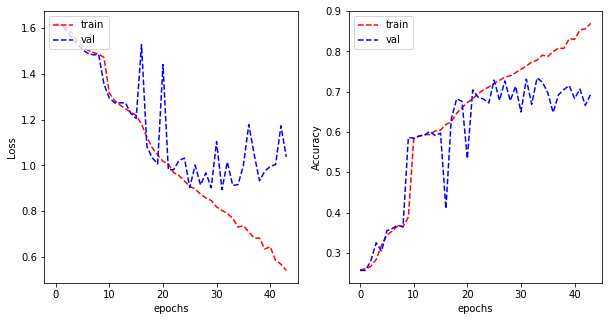

In [58]:
plot_fit_history(VGG_history.history['loss'], VGG_history.history['val_loss'],
                    VGG_history.history['categorical_accuracy'], VGG_history.history['val_categorical_accuracy'])

 Model seems to be overfitting. There are a couple of things we can do here. We have gone with removing 1 VGG block as well as add a dropout layer

In [59]:
(test_y, pred_y) = predict_model(VGG_model)

In [60]:
show_stats(test_y, pred_y)

Accuracy score:  0.6976056427125507
F1 score:  0.623684561596697
              precision    recall  f1-score   support

           0       0.61      0.70      0.65     12487
           1       0.70      0.63      0.66     15833
           2       0.84      0.90      0.87     25269
           3       0.36      0.28      0.31      9643

    accuracy                           0.70     63232
   macro avg       0.63      0.63      0.62     63232
weighted avg       0.68      0.70      0.69     63232



In [61]:
plot_confusion_matrix(test_y, pred_y)

TypeError: plot_confusion_matrix() missing 1 required positional argument: 'target_names'

# VGG 2 model with Dropout

In [83]:
VGG2_model = keras.Sequential([
    #VGG block 1
    keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2, 2)),
    
    keras.layers.Flatten(),
    
    keras.layers.Dense(128, activation='relu'), #, kernel_regularizer=keras.regularizers.l2(reg_lambda)),
    keras.layers.Dropout(.2),
    keras.layers.Dense(OUTPUT_CLASSES, activation='relu',) # kernel_regularizer=keras.regularizers.l2(reg_lambda))
])

In [84]:
compile_model(VGG2_model)

In [85]:
VGG_model2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 27, 27, 32)        896       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 27, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 2304)             

In [86]:
VGG2_history = fit_model(VGG2_model)

start  12:23:40
Epoch 1/10000
186/186 [==============================] - 13s 66ms/step - loss: 1.3843 - categorical_accuracy: 0.2510 - accuracy: 0.2510 - val_loss: 1.3811 - val_categorical_accuracy: 0.2567 - val_accuracy: 0.2567
Epoch 2/10000
186/186 [==============================] - 12s 63ms/step - loss: 1.3682 - categorical_accuracy: 0.2951 - accuracy: 0.2951 - val_loss: 1.3088 - val_categorical_accuracy: 0.4093 - val_accuracy: 0.4093
Epoch 3/10000
186/186 [==============================] - 12s 64ms/step - loss: 1.2880 - categorical_accuracy: 0.4329 - accuracy: 0.4329 - val_loss: 1.2650 - val_categorical_accuracy: 0.4154 - val_accuracy: 0.4154
Epoch 4/10000
186/186 [==============================] - 13s 69ms/step - loss: 1.2256 - categorical_accuracy: 0.5019 - accuracy: 0.5019 - val_loss: 1.1416 - val_categorical_accuracy: 0.5811 - val_accuracy: 0.5811
Epoch 5/10000
186/186 [==============================] - 13s 70ms/step - loss: 1.1331 - categorical_accuracy: 0.5449 - accuracy: 0.5

186/186 [==============================] - 13s 70ms/step - loss: 0.4957 - categorical_accuracy: 0.8105 - accuracy: 0.8105 - val_loss: 0.6725 - val_categorical_accuracy: 0.7453 - val_accuracy: 0.7453
Epoch 40/10000
186/186 [==============================] - 13s 68ms/step - loss: 0.4930 - categorical_accuracy: 0.8142 - accuracy: 0.8142 - val_loss: 0.6914 - val_categorical_accuracy: 0.7377 - val_accuracy: 0.7377
Epoch 41/10000
186/186 [==============================] - 13s 68ms/step - loss: 0.4664 - categorical_accuracy: 0.8240 - accuracy: 0.8240 - val_loss: 0.7030 - val_categorical_accuracy: 0.7453 - val_accuracy: 0.7453
stop  12:32:40
Took =  0:08:59.756163


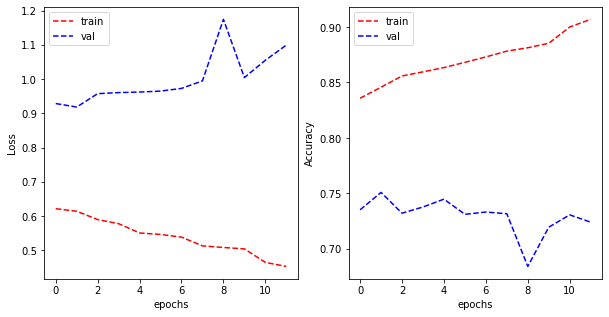

In [87]:
plot_fit_history(VGG_history.history['loss'], VGG_history.history['val_loss'],
                    VGG_history.history['categorical_accuracy'], VGG_history.history['val_categorical_accuracy'])

Performance seems slightly better, but definately can be imporved upon. As of right now, overfitting seems to be the main problem.

In [75]:
(test_y, pred_y) = predict_model(VGG_model)

In [76]:
show_stats(test_y, pred_y)

Accuracy score:  0.697510754048583
F1 score:  0.6235443016330974
              precision    recall  f1-score   support

           0       0.61      0.70      0.65     12483
           1       0.70      0.63      0.66     15837
           2       0.84      0.90      0.87     25269
           3       0.36      0.28      0.31      9643

    accuracy                           0.70     63232
   macro avg       0.63      0.63      0.62     63232
weighted avg       0.68      0.70      0.69     63232



In [ ]:
plot_confusion_matrix(test_y, pred_y)

## Data Augumentation

In [92]:
aug_train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                   rotation_range=90, width_shift_range=0.2,
                                   height_shift_range=0.2, brightness_range=[0.5,1.5])
aug_val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32
columns = ['cellType_0', 'cellType_1', 'cellType_2', 'cellType_3']

aug_train_generator = aug_train_datagen.flow_from_dataframe(
    dataframe = train_data,
    directory = './patch_images',
    x_col = 'ImageName',
    y_col = columns,
    target_size = (27, 27),
    batch_size = batch_size,
    class_mode = 'raw',
    shuffle=False
)

aug_validation_generator = aug_val_datagen.flow_from_dataframe(
    dataframe=val_data,
    directory = './patch_images',
    x_col = 'ImageName',
    y_col = columns,
    target_size = (27, 27),
    batch_size = batch_size,
    class_mode = 'raw',
    shuffle = False
)

Found 5937 validated image filenames.
Found 1979 validated image filenames.


In [95]:
compile_model(VGG_model)

In [96]:
print("Training started...")
now = datetime.datetime.now()

VGG2_history = VGG_model.fit(aug_train_generator, validation_data=aug_validation_generator, epochs=100, verbose=0)

print("Took = ", datetime.datetime.now() - now)

Training started...
Took =  0:29:12.716854


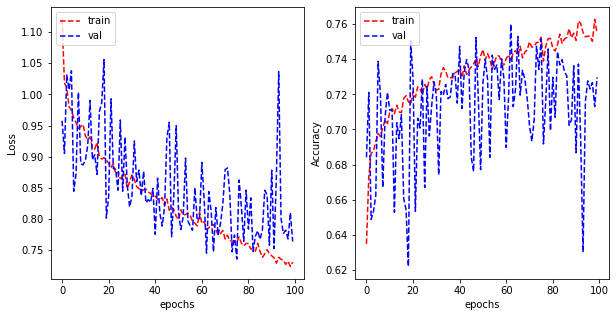

In [97]:
plot_fit_history(VGG2_history.history['loss'], VGG2_history.history['val_loss'],
                    VGG2_history.history['categorical_accuracy'], VGG2_history.history['val_categorical_accuracy'])